## Load in the bridge dataset

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
bridges_full = pd.read_excel('../data/raw/BMMS_overview.xlsx')
bridges_full

road      km                   type  LRPName               name  \
0         N1   1.800            Box Culvert  LRP001a                  .   
1         N1   4.925            Box Culvert  LRP004b                  .   
2         N1   8.976       PC Girder Bridge  LRP008b  Kanch pur Bridge.   
3         N1  10.880            Box Culvert  LRP010b   NOYAPARA CULVERT   
4         N1  10.897            Box Culvert  LRP010c     ADUPUR CULVERT   
...      ...     ...                    ...      ...                ...   
20410  Z8806  83.728            Box Culvert  LRP083a                  .   
20411  Z8810   3.981  Steel Beam & RCC Slab  LRP003b                  .   
20412  Z8814  20.730  Baily with Steel Deck  LRP020b     Kalbari Bridge   
20413  Z8910  28.880      RCC Girder Bridge  LRP028a   Narainpur Bridge   
20414  Z8910  33.530      RCC Girder Bridge  LRP033c       Jor Bridge 2   

       length condition  structureNr  \
0       11.30         A       117861   
1        6.60         A       117862   
2      394.23         A       119889   
3        6.30         A       112531   
4        6.30         A       112532   
...       ...       ...          ...   
20410    1.78         D       110470   
20411   27.20         D       113458   
20412   30.50         D       121147   
20413    9.50         D       119249   
20414    6.00         D       119254   

                                                roadName  chainage  width  \
0      Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...     1.800   19.5   
1      Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...     4.925   35.4   
2      Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...     8.976    NaN   
3      Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...    10.880   12.2   
4      Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...    10.897   12.2   
...                                                  ...       ...    ...   
20410  Lebukhali-Dumki-Boga-Bauphal-Kalaiya-Dashmina-...    83.728    7.6   
20411  Bakerganj-Padrishibpur-Kathaltali-Subidkhali-B...     3.981    3.2   
20412  Barguna (Dakhin Ramna Kheya Ghat)-Dewatala-Mat...    20.730    NaN   
20413       Barisal (Bairagirpool)-Tumchar-Bauphaul Road    28.880    NaN   
20414       Barisal (Bairagirpool)-Tumchar-Bauphaul Road    33.530    NaN   

       constructionYear  spans     zone      circle     division  \
0                2005.0    2.0    Dhaka       Dhaka  Narayanganj   
1                2006.0    1.0    Dhaka       Dhaka  Narayanganj   
2                   NaN    NaN    Dhaka       Dhaka  Narayanganj   
3                1992.0    2.0    Dhaka       Dhaka  Narayanganj   
4                1984.0    2.0    Dhaka       Dhaka  Narayanganj   
...                 ...    ...      ...         ...          ...   
20410            1980.0    1.0  Barisal  Patuakhali      Barguna   
20411            1979.0    5.0  Barisal     Barisal      Barisal   
20412               NaN    NaN  Barisal     Barisal     Pirojpur   
20413               NaN    NaN  Barisal  Patuakhali   Patuakhali   
20414               NaN    NaN  Barisal  Patuakhali   Patuakhali   

        sub-division        lat        lon EstimatedLoc  
0      Narayanganj-1  23.698739  90.458861  interpolate  
1      Narayanganj-1  23.694664  90.487775  interpolate  
2      Narayanganj-1  23.705060  90.523214  interpolate  
3          Vitikandi  23.694391  90.537574  interpolate  
4          Vitikandi  23.694302  90.537707  interpolate  
...              ...        ...        ...          ...  
20410        Barguna  22.183448  90.299962  interpolate  
20411      Barisal-1  22.519353  90.310063  interpolate  
20412       Kawkhali  22.282704  89.968512  interpolate  
20413     Patuakhali  22.510650  90.535314  interpolate  
20414     Patuakhali  22.474325  90.557335  interpolate  

[20415 rows x 20 columns]

In [41]:
# Verify that there are no duplicate structure numbers 
bridges_full[bridges_full.duplicated('structureNr')]

Empty DataFrame
Columns: [road, km, type, LRPName, name, length, condition, structureNr, roadName, chainage, width, constructionYear, spans, zone, circle, division, sub-division, lat, lon, EstimatedLoc]
Index: []

In [42]:
# From the previous assignment we know that bridges that are duplicated on either LRPName or coordinates, are mostly the same on other values as well. Some have minimal differences on bridge length or have missing values. Because of this, this function identifies duplicates based on only LRPName and chainage, for latter of which has been added as addittional check. 
def find_dupes_LRP(dataframe):
    df_copy = dataframe.copy()
    df_copy.sort_values(by=['LRPName', 'width'], inplace=True) #sort in such a way that the NaN values will be the bottom row
    df_copy.reset_index(inplace=True)
    # Check how many times each of the LRPs occur in the dataframe
    LRP_values = df_copy['LRPName'].value_counts()
    LRP_list = list(set((df_copy['LRPName'].to_list())))
    to_be_removed = []
    
    # For each LRP in the list, check if it has a duplicate, if so delete the duplicates while making sure that the worst bridge condition is kept
    for LRP in LRP_list:
        if LRP_values[LRP] == 2:
            bridge1_index = df_copy.index.get_loc(df_copy[df_copy['LRPName'] == LRP].index[0])
            if df_copy.loc[bridge1_index, 'chainage'] == df_copy.loc[bridge1_index+1, 'chainage']: 
                con_bridge1 = df_copy.loc[bridge1_index, 'condition']
                con_bridge2 = df_copy.loc[bridge1_index+1, 'condition']
                if con_bridge1 < con_bridge2:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge2
                to_be_removed.append(df_copy.loc[bridge1_index+1, 'structureNr'])
            
        if LRP_values[LRP] == 3:
            bridge1_index = df_copy.index.get_loc(df_copy[df_copy['LRPName'] == LRP].index[0])
            if df_copy.loc[bridge1_index, 'chainage'] == df_copy.loc[bridge1_index+1, 'chainage'] == df_copy.loc[bridge1_index+2, 'chainage']:
                con_bridge1 = df_copy.loc[bridge1_index, 'condition']
                con_bridge2 = df_copy.loc[bridge1_index+1, 'condition']
                con_bridge3 = df_copy.loc[bridge1_index+2, 'condition']
                if con_bridge1 < con_bridge2:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge2
                if con_bridge1 < con_bridge3:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge3
                to_be_removed.append(df_copy.loc[bridge1_index+1, 'structureNr'])
                to_be_removed.append(df_copy.loc[bridge1_index+2, 'structureNr'])
            
        if LRP_values[LRP] == 4:
            bridge1_index = df_copy.index.get_loc(df_copy[df_copy['LRPName'] == LRP].index[0])
            if df_copy.loc[bridge1_index, 'chainage'] == df_copy.loc[bridge1_index+1, 'chainage'] == df_copy.loc[bridge1_index+2, 'chainage'] == df_copy.loc[bridge1_index+3, 'chainage']:
                con_bridge1 = df_copy.loc[bridge1_index, 'condition']
                con_bridge2 = df_copy.loc[bridge1_index+1, 'condition']
                con_bridge3 = df_copy.loc[bridge1_index+2, 'condition']
                con_bridge4 = df_copy.loc[bridge1_index+3, 'condition']
                if con_bridge1 < con_bridge2:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge2
                if con_bridge1 < con_bridge3:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge3
                if con_bridge1 < con_bridge4:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge4
                to_be_removed.append(df_copy.loc[bridge1_index+1, 'structureNr'])
                to_be_removed.append(df_copy.loc[bridge1_index+2, 'structureNr'])
                to_be_removed.append(df_copy.loc[bridge1_index+3, 'structureNr'])
    
    # Make a new dataframe containing only the cleaned bridges, and the ones that do not have a dupe
    df_cleaned = df_copy[~df_copy['structureNr'].isin(to_be_removed)]
    return df_cleaned

In [43]:
# Make a smaller dataframe to test if the code works the way it is supposed to
bridges_N1 = bridges_full[bridges_full['road']=='N1']
bridges_N1sort = bridges_N1.sort_values(by='LRPName')
bridges_N1sort.reset_index(inplace=True)
LRP_valuesN1 = bridges_N1sort['LRPName'].value_counts()
bridge_LRPN1 = bridges_N1sort[bridges_N1sort['LRPName'].isin(LRP_valuesN1[LRP_valuesN1>1].index)]
bridge_slice = bridge_LRPN1.head(8)
bridge_slice

index road      km               type  LRPName  \
2       2   N1   8.976   PC Girder Bridge  LRP008b   
3   12706   N1   8.976   PC Girder Bridge  LRP008b   
11      9   N1  12.660   PC Girder Bridge  LRP013a   
12     10   N1  12.660   PC Girder Bridge  LRP013a   
13      8   N1  12.660   PC Girder Bridge  LRP013a   
17  14588   N1  17.134   PC Girder Bridge  LRP017b   
18  12707   N1  17.134  RCC Girder Bridge  LRP017b   
19  14590   N1  17.722   PC Girder Bridge  LRP018a   

                           name  length condition  structureNr  \
2             Kanch pur Bridge.  394.23         A       119889   
3     KANCHPUR PC GIRDER BRIDGE  397.00         C       101102   
11                MADAN PUR (R)   26.30         A       109841   
12           MADANPUR BRIDGE(L)   26.30         A       109838   
13          Madanpur Bridge.(L)   27.50         A       119897   
17  LANGOLBANDO PC GIDER BRIDGE  159.50         B       109808   
18          Langalbandh Bridge.  159.52         C       119909   
19         DARIKANDI BRIDGE (L)   20.00         B       109853   

                                             roadName  ...  width  \
2   Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...  ...    NaN   
3   Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...  ...  14.65   
11  Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...  ...   9.20   
12  Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...  ...   9.20   
13  Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...  ...    NaN   
17  Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...  ...  17.80   
18  Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...  ...    NaN   
19  Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...  ...   9.20   

    constructionYear  spans   zone circle     division   sub-division  \
2                NaN    NaN  Dhaka  Dhaka  Narayanganj  Narayanganj-1   
3             1986.0    8.0  Dhaka  Dhaka  Narayanganj  Narayanganj-1   
11            2003.0    1.0  Dhaka  Dhaka  Narayanganj      Vitikandi   
12            2003.0    1.0  Dhaka  Dhaka  Narayanganj      Vitikandi   
13               NaN    NaN  Dhaka  Dhaka  Narayanganj      Vitikandi   
17            1998.0    5.0  Dhaka  Dhaka  Narayanganj      Vitikandi   
18               NaN    NaN  Dhaka  Dhaka  Narayanganj      Vitikandi   
19            2002.0    1.0  Dhaka  Dhaka  Narayanganj      Vitikandi   

          lat        lon  EstimatedLoc  
2   23.705060  90.523214   interpolate  
3   23.705060  90.523214   interpolate  
11  23.685583  90.551208   interpolate  
12  23.685583  90.551208   interpolate  
13  23.685583  90.551208   interpolate  
17  23.654426  90.576730   interpolate  
18  23.654426  90.576730   interpolate  
19  23.651571  90.581494   interpolate  

[8 rows x 21 columns]

In [44]:
df_slice_clean = find_dupes_LRP(bridge_slice)
df_slice_clean

level_0  index road      km              type  LRPName  \
0        3  12706   N1   8.976  PC Girder Bridge  LRP008b   
2       11      9   N1  12.660  PC Girder Bridge  LRP013a   
5       17  14588   N1  17.134  PC Girder Bridge  LRP017b   
7       19  14590   N1  17.722  PC Girder Bridge  LRP018a   

                          name  length condition  structureNr  ...  width  \
0    KANCHPUR PC GIRDER BRIDGE   397.0         C       101102  ...  14.65   
2                MADAN PUR (R)    26.3         A       109841  ...   9.20   
5  LANGOLBANDO PC GIDER BRIDGE   159.5         C       109808  ...  17.80   
7         DARIKANDI BRIDGE (L)    20.0         B       109853  ...   9.20   

   constructionYear  spans   zone  circle     division   sub-division  \
0            1986.0    8.0  Dhaka   Dhaka  Narayanganj  Narayanganj-1   
2            2003.0    1.0  Dhaka   Dhaka  Narayanganj      Vitikandi   
5            1998.0    5.0  Dhaka   Dhaka  Narayanganj      Vitikandi   
7            2002.0    1.0  Dhaka   Dhaka  Narayanganj      Vitikandi   

         lat        lon  EstimatedLoc  
0  23.705060  90.523214   interpolate  
2  23.685583  90.551208   interpolate  
5  23.654426  90.576730   interpolate  
7  23.651571  90.581494   interpolate  

[4 rows x 22 columns]

The code is correct: only one of the duplicated bridges is kept, with the worst condition of the lot. In addition, the dataframe is sorted in such a way, that the kept bridge has a minimal amount of NaN-values. Lastly, LRPs that do not have a dupe, are not touched and therefor remain in the dataframe as such

## Start cleaning the bridges on the identified roads

In [45]:
roads_df = pd.read_csv('../data/semi-processed/identified_roads_final.csv')
roads_list = roads_df['road'].to_list()
roads = set(roads_list)
len(roads)

26

In [46]:
# To get an insight into how many bridges have been removed, check the original amount of bridges
bridges_df_list = []
for road in roads:
    dataframe = bridges_full[bridges_full['road'] == road]
    bridges_df_list.append(dataframe)
    df_bridges_full = pd.concat(bridges_df_list)

df_bridges_full

road      km                   type  LRPName  \
2820    R240   3.008            Box Culvert  LRP003a   
2821    R240   4.905            Box Culvert  LRP004b   
2822    R240   7.065            Box Culvert  LRP007a   
2823    R240   7.924           Slab Culvert  LRP007b   
2824    R240  11.644            Box Culvert  LRP011c   
...      ...     ...                    ...      ...   
19766  Z1042  22.147  Truss with Steel Deck  LRP023a   
19767  Z1042  24.315             RCC Bridge  LRP025a   
19768  Z1042  25.086  Baily with Steel Deck  LRP026a   
19769  Z1042  25.340           Slab Culvert  LRP026c   
19770  Z1042  25.715      RCC Girder Bridge  LRP027a   

                                  name  length condition  structureNr  \
2820          SAYASTAGONG BAZAR BRIDGE     1.5         A       102182   
2821                KALIMKAGAR CULVERT     3.5         A       102189   
2822                  RATANPUR CULVERT     6.0         A       102199   
2823                  PAIKPARA CULVERT     6.0         A       102204   
2824                 NADAI BOX CULVERT     8.3         A       102225   
...                                ...     ...       ...          ...   
19766  KARIMPUR BAILEY WITH STEEL DECK    30.0         D       102538   
19767         NOYAGOR RCC GIDER BRIDGE     6.5         D       102545   
19768    KAMALA BAILEY WITH STEEL DECK    39.0         D       102547   
19769                          KAMALLA     4.0         D       114234   
19770                           KAMALL    10.0         D       114235   

                                                roadName  chainage  width  \
2820   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     3.008    8.5   
2821   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     4.905    8.5   
2822   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     7.065    7.3   
2823   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     7.924    7.3   
2824   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...    11.644    9.8   
...                                                  ...       ...    ...   
19766  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    22.147    3.5   
19767  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    24.315    4.8   
19768  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    25.086    3.4   
19769  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    25.340    4.8   
19770  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    25.715    4.8   

       constructionYear  spans     zone         circle  division sub-division  \
2820             1978.0    1.0   Sylhet  Moulavi Bazar  Habiganj  Shaistagonj   
2821             1978.0    1.0   Sylhet  Moulavi Bazar  Habiganj  Shaistagonj   
2822             1978.0    1.0   Sylhet  Moulavi Bazar  Habiganj  Shaistagonj   
2823             1978.0    1.0   Sylhet  Moulavi Bazar  Habiganj  Shaistagonj   
2824             1978.0    2.0   Sylhet  Moulavi Bazar  Habiganj  Shaistagonj   
...                 ...    ...      ...            ...       ...          ...   
19766            1965.0    1.0  Comilla        Comilla   Comilla     Gouripur   
19767            1970.0    1.0  Comilla        Comilla   Comilla     Gouripur   
19768            1981.0    1.0  Comilla        Comilla   Comilla     Gouripur   
19769            1964.0    1.0  Comilla        Comilla   Comilla     Gouripur   
19770            1969.0    1.0  Comilla        Comilla   Comilla     Gouripur   

             lat        lon EstimatedLoc  
2820   24.278418  91.452670  interpolate  
2821   24.294645  91.455733  interpolate  
2822   24.311838  91.445329  interpolate  
2823   24.318116  91.441382  interpolate  
2824   24.348678  91.425837  interpolate  
...          ...        ...          ...  
19766  23.627827  90.931662  interpolate  
19767  23.645513  90.929641  interpolate  
19768  23.651693  90.927842  interpolate  
19769  23.653872  90.927257  interpolate  
19770  23.657028  90.925996  interpolate  

[2862 rows x 20 columns]

In [47]:
df_bridges_full.isna().sum()

road                  0
km                    0
type                  0
LRPName               0
name                  0
length                1
condition             0
structureNr           0
roadName              0
chainage              0
width               463
constructionYear    463
spans               463
zone                  0
circle                0
division              0
sub-division          0
lat                   0
lon                   0
EstimatedLoc          0
dtype: int64

In [48]:
def correct_dupes_LRP(df, road_list):
    # Empty list to save in each cleaned dataframe per road
    full_cleaned_df_list = []
    
    # For each road, go trough the find_dupes_LRP function
    for road in road_list:
        dataframe = df[df['road'] == road]
        dataframe_cleaned = find_dupes_LRP(dataframe)
        full_cleaned_df_list.append(dataframe_cleaned)
    
    # Once the bridges on all the roads have been cleaned, concat the seperate road dataframes into one big dataframe again    
    df_cleaned = pd.concat(full_cleaned_df_list)
    return df_cleaned

In [49]:
cleaned_bridges_LRP = correct_dupes_LRP(bridges_full, roads)
cleaned_bridges_LRP

index   road      km                   type  LRPName  \
0    2820   R240   3.008            Box Culvert  LRP003a   
1   15342   R240   3.205            Box Culvert  LRP003c   
2    2821   R240   4.905            Box Culvert  LRP004b   
3    2822   R240   7.065            Box Culvert  LRP007a   
4    2823   R240   7.924           Slab Culvert  LRP007b   
..    ...    ...     ...                    ...      ...   
41  17324  Z1042  26.922  Truss with Steel Deck  LRP028a   
43   5616  Z1042  27.607            Box Culvert  LRP029a   
44   5617  Z1042  28.493      RCC Girder Bridge  LRP029b   
45  11343  Z1042  29.183      RCC Girder Bridge  LRP030a   
47   5619  Z1042  31.775      RCC Girder Bridge  LRP034a   

                        name  length condition  structureNr  \
0   SAYASTAGONG BAZAR BRIDGE     1.5         A       102182   
1          NICH GAON CULVERT     3.0         B       102186   
2         KALIMKAGAR CULVERT     3.5         A       102189   
3           RATANPUR CULVERT     6.0         A       102199   
4           PAIKPARA CULVERT     6.0         A       102204   
..                       ...     ...       ...          ...   
41            KAMILLA BRIDGE    42.0         C       102537   
43                   DAMURIA     4.5         A       102539   
44            DAMURIA BRIDGE    14.5         A       102540   
45          BARKA BAZ BRIDGE    14.0         B       102544   
47             Shalpa Bridge    36.6         A       120374   

                                             roadName  ...  width  \
0   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...  ...    8.5   
1   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...  ...    8.6   
2   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...  ...    8.5   
3   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...  ...    7.3   
4   Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...  ...    7.3   
..                                                ...  ...    ...   
41  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...  ...    3.5   
43  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...  ...    7.3   
44  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...  ...    4.8   
45  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...  ...    4.8   
47  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...  ...    NaN   

    constructionYear  spans     zone         circle      division  \
0             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
1             1998.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
2             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
3             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
4             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
..               ...    ...      ...            ...           ...   
41            1995.0    1.0  Comilla        Comilla       Comilla   
43            1992.0    1.0  Comilla        Comilla       Comilla   
44            1970.0    1.0  Comilla        Comilla       Comilla   
45            1984.0    1.0  Comilla        Comilla       Comilla   
47               NaN    NaN  Comilla        Comilla  Brahmanbaria   

    sub-division        lat        lon  EstimatedLoc  
0    Shaistagonj  24.278418  91.452670   interpolate  
1    Shaistagonj  24.279879  91.451990   interpolate  
2    Shaistagonj  24.294645  91.455733   interpolate  
3    Shaistagonj  24.311838  91.445329   interpolate  
4    Shaistagonj  24.318116  91.441382   interpolate  
..           ...        ...        ...           ...  
41      Gouripur  23.666574  90.919989   interpolate  
43      Gouripur  23.672347  90.921013   interpolate  
44      Gouripur  23.679407  90.917991   interpolate  
45      Gouripur  23.683620  90.913329   interpolate  
47  Bancharampur  23.702074  90.899216   interpolate  

[2399 rows x 21 columns]

In [50]:
cleaned_bridges_LRP.isna().sum()

index                0
road                 0
km                   0
type                 0
LRPName              0
name                 0
length               0
condition            0
structureNr          0
roadName             0
chainage             0
width               30
constructionYear    30
spans               30
zone                 0
circle               0
division             0
sub-division         0
lat                  0
lon                  0
EstimatedLoc         0
dtype: int64

In this first iteration of cleaning, 427 duplicated bridges got removed. With this, the amount of missing values also greatly decreased, from 426 entries with missing values to only 21. Duplicates can also occur if bridges are put on exactly the same place, but do not have the same LRP. These duplicates will also be handeled 

## Check for dupes based on coordinates

In [51]:
lat_values = cleaned_bridges_LRP['lat'].value_counts()
lat_values.value_counts()

count
1    2371
2      14
Name: count, dtype: int64

In [52]:
lon_values = cleaned_bridges_LRP['lon'].value_counts()
lon_values.value_counts()

count
1    2368
2      14
3       1
Name: count, dtype: int64

As there are duplicates in the coordinates, repeat the same steps as before. 

In [53]:
def find_dupes_coord(dataframe):
    df_copy = dataframe.copy()
    df_copy.sort_values(by=['lat', 'width'], inplace=True) #sort that the matching coordinates will be paired
    df_copy.reset_index(inplace=True)
    to_be_removed = []
    lat_values = df_copy['lat'].value_counts()
    lat_list = list(set((df_copy['lat'].to_list())))
    
    for lat in lat_list:
        if lat_values[lat] == 2:
            # For each duped latitude, check if the londitude also matches, before continuing
            bridge1_index = df_copy.index.get_loc(df_copy[df_copy['lat'] == lat].index[0])
            if df_copy.loc[bridge1_index, 'lon'] == df_copy.loc[bridge1_index+1, 'lon']: 
                con_bridge1 = df_copy.loc[bridge1_index, 'condition']
                con_bridge2 = df_copy.loc[bridge1_index+1, 'condition']
                if con_bridge1 < con_bridge2:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge2
                to_be_removed.append(df_copy.loc[bridge1_index+1, 'structureNr'])
            
    df_cleaned = df_copy[~df_copy['structureNr'].isin(to_be_removed)]
    return df_cleaned

In [54]:
def correct_dupes_coord(df, road_list):
    full_cleaned_df_list = []
    
    for road in road_list:
        dataframe = df[df['road'] == road]
        dataframe_cleaned = find_dupes_coord(dataframe)
        full_cleaned_df_list.append(dataframe_cleaned)
        
    df_cleaned = pd.concat(full_cleaned_df_list)
    return df_cleaned

In [55]:
df_cleaned_coord = correct_dupes_coord(cleaned_bridges_LRP, roads)
df_cleaned_coord

level_0  index   road      km                   type  LRPName  \
0         0   2820   R240   3.008            Box Culvert  LRP003a   
1         1  15342   R240   3.205            Box Culvert  LRP003c   
2         2   2821   R240   4.905            Box Culvert  LRP004b   
3         3   2822   R240   7.065            Box Culvert  LRP007a   
4         4   2823   R240   7.924           Slab Culvert  LRP007b   
..      ...    ...    ...     ...                    ...      ...   
32       41  17324  Z1042  26.922  Truss with Steel Deck  LRP028a   
33       43   5616  Z1042  27.607            Box Culvert  LRP029a   
34       44   5617  Z1042  28.493      RCC Girder Bridge  LRP029b   
35       45  11343  Z1042  29.183      RCC Girder Bridge  LRP030a   
36       47   5619  Z1042  31.775      RCC Girder Bridge  LRP034a   

                        name  length condition  structureNr  ... width  \
0   SAYASTAGONG BAZAR BRIDGE     1.5         A       102182  ...   8.5   
1          NICH GAON CULVERT     3.0         B       102186  ...   8.6   
2         KALIMKAGAR CULVERT     3.5         A       102189  ...   8.5   
3           RATANPUR CULVERT     6.0         A       102199  ...   7.3   
4           PAIKPARA CULVERT     6.0         A       102204  ...   7.3   
..                       ...     ...       ...          ...  ...   ...   
32            KAMILLA BRIDGE    42.0         C       102537  ...   3.5   
33                   DAMURIA     4.5         A       102539  ...   7.3   
34            DAMURIA BRIDGE    14.5         A       102540  ...   4.8   
35          BARKA BAZ BRIDGE    14.0         B       102544  ...   4.8   
36             Shalpa Bridge    36.6         A       120374  ...   NaN   

    constructionYear  spans     zone         circle      division  \
0             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
1             1998.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
2             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
3             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
4             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
..               ...    ...      ...            ...           ...   
32            1995.0    1.0  Comilla        Comilla       Comilla   
33            1992.0    1.0  Comilla        Comilla       Comilla   
34            1970.0    1.0  Comilla        Comilla       Comilla   
35            1984.0    1.0  Comilla        Comilla       Comilla   
36               NaN    NaN  Comilla        Comilla  Brahmanbaria   

    sub-division        lat        lon  EstimatedLoc  
0    Shaistagonj  24.278418  91.452670   interpolate  
1    Shaistagonj  24.279879  91.451990   interpolate  
2    Shaistagonj  24.294645  91.455733   interpolate  
3    Shaistagonj  24.311838  91.445329   interpolate  
4    Shaistagonj  24.318116  91.441382   interpolate  
..           ...        ...        ...           ...  
32      Gouripur  23.666574  90.919989   interpolate  
33      Gouripur  23.672347  90.921013   interpolate  
34      Gouripur  23.679407  90.917991   interpolate  
35      Gouripur  23.683620  90.913329   interpolate  
36  Bancharampur  23.702074  90.899216   interpolate  

[2385 rows x 22 columns]

In [56]:
df_cleaned_coord.isna().sum()

level_0              0
index                0
road                 0
km                   0
type                 0
LRPName              0
name                 0
length               0
condition            0
structureNr          0
roadName             0
chainage             0
width               18
constructionYear    18
spans               18
zone                 0
circle               0
division             0
sub-division         0
lat                  0
lon                  0
EstimatedLoc         0
dtype: int64

In this last and final iteration of cleaning, 11 bridges got removed. With this, the missing values got reduced to 17 entries

## Find out which bridge width corresponds to which amount of lanes
In order to make the probability of the bridges braking down in the model as accurate as possible, the amount of lanes each bridge has will be added based on the width of the bridge 

In [57]:
# Import the RMMS width files from the N1 and N2
N1_width = pd.read_table('../data/raw/N1.widths.processed.txt')
N2_width = pd.read_table('../data/raw/N2.widths.processed.txt')

In [58]:
N1_width

roadNo  roadId  startChainage  endChainage  width  nrLanes
0      N1    1585          0.000        0.130   29.7        8
1      N1    1585          0.130        0.400   14.0        4
2      N1    1585          0.400        1.050   28.3        8
3      N1    1585          1.050        5.100   16.5        5
4      N1    1585          5.100        6.200   16.2        5
..    ...     ...            ...          ...    ...      ...
59     N1    1585        429.682      437.968    5.8        2
60     N1    1585        437.968      444.511    5.7        2
61     N1    1585        444.511      451.519    5.6        2
62     N1    1585        451.519      459.326    5.7        2
63     N1    1585        459.326      462.254    6.3        2

[64 rows x 6 columns]

In [59]:
def find_min_max(dataframe, lanes):
    min, max = 100, 0 # pick numbers that will be overruled 
    df_lanes = dataframe[dataframe['nrLanes']==lanes]
    df_lanes.reset_index(inplace=True)
    for row in range(len(df_lanes)):
        if df_lanes.loc[row, 'width'] > max:
            max = df_lanes.at[row, 'width']
        if df_lanes.loc[row, 'width'] < min:
            min = df_lanes.at[row, 'width']
    return min, max

In [60]:
print('Information from N1 width files')
for lanes in range(9):
    min_lane, max_lane = find_min_max(N1_width, lanes)
    print(f'Lanes: {lanes} - min width: {min_lane} meters - max width: {max_lane} meters')

Information from N1 width files
Lanes: 0 - min width: 100 meters - max width: 0 meters
Lanes: 1 - min width: 100 meters - max width: 0 meters
Lanes: 2 - min width: 5.6 meters - max width: 8.2 meters
Lanes: 3 - min width: 10.3 meters - max width: 10.3 meters
Lanes: 4 - min width: 14.0 meters - max width: 15.0 meters
Lanes: 5 - min width: 15.3 meters - max width: 16.5 meters
Lanes: 6 - min width: 18.6 meters - max width: 46.9 meters
Lanes: 7 - min width: 100 meters - max width: 0 meters
Lanes: 8 - min width: 25.7 meters - max width: 29.7 meters


In [61]:
# There is an outlier in the 6 lanes maximum
N1_width[N1_width['nrLanes'] == 6] # so it has to be 18.9 meters

roadNo  roadId  startChainage  endChainage  width  nrLanes
18     N1    1585         22.330       22.800   46.9        6
26     N1    1585         41.761       45.819   18.9        6
27     N1    1585         45.819       54.029   18.9        6
28     N1    1585         54.029      229.046   18.8        6
30     N1    1585        230.606      232.754   18.6        6

In [62]:
print('Information from N2 width files')
for lanes in range(9):
    min_lane, max_lane = find_min_max(N2_width, lanes)
    print(f'Lanes: {lanes} - min width: {min_lane} meters - max width: {max_lane} meters')

Information from N2 width files
Lanes: 0 - min width: 100 meters - max width: 0 meters
Lanes: 1 - min width: 100 meters - max width: 0 meters
Lanes: 2 - min width: 7.0 meters - max width: 8.0 meters
Lanes: 3 - min width: 8.0 meters - max width: 12.0 meters
Lanes: 4 - min width: 13.0 meters - max width: 140.0 meters
Lanes: 5 - min width: 17.2 meters - max width: 17.2 meters
Lanes: 6 - min width: 18.0 meters - max width: 21.0 meters
Lanes: 7 - min width: 100 meters - max width: 0 meters
Lanes: 8 - min width: 100 meters - max width: 0 meters


In [63]:
# There is an outlier in the 4 lanes maximum
N2_width[N2_width['nrLanes'] == 4] # so it has to be 17.0 meters

roadNo  roadId  startChainage  endChainage  width  nrLanes
0       N2    1479          0.000        0.130   15.2        4
1       N2    1479          0.130        0.260   14.0        4
10      N2    1479         10.996       11.276   14.0        4
16      N2    1479         25.416       26.036   13.4        4
19      N2    1479         27.376       27.626   13.4        4
20      N2    1479         27.626       27.876   13.4        4
21      N2    1479         27.876       28.426   14.0        4
23      N2    1479         29.826       30.076   13.4        4
24      N2    1479         30.076       30.426  140.0        4
34      N2    1479         42.526       42.616   17.0        4
35      N2    1479         42.616       42.766   17.0        4
36      N2    1479         42.766       42.916   14.0        4
38      N2    1479         50.171       50.391   17.0        4
40      N2    1479         51.671       51.871   16.0        4
42      N2    1479         52.671       52.821   16.0        4
44      N2    1479         54.436       54.726   16.4        4
46      N2    1479         58.876       59.126   16.0        4
48      N2    1479         63.848       64.048   16.0        4
52      N2    1479         70.098       70.848   16.0        4
54      N2    1479         71.108       73.598   17.0        4
55      N2    1479         73.598       73.848   13.5        4
58      N2    1479         85.713       85.963   14.0        4
62      N2    1479         92.246       92.796   16.0        4
69      N2    1479        116.126      116.516   13.0        4
77      N2    1479        141.181      141.431   16.0        4
80      N2    1479        145.841      146.081   16.0        4
100     N2    1479        181.580      181.730   16.0        4
102     N2    1479        190.820      190.970   16.0        4
120     N2    1479        225.323      225.528   16.0        4

Based on the width values from the RMMS files, and the assumption that roads are always symmetrical, and the values from this official Bangladeshi source (https://www.rhd.gov.bd/Documents/RoadDesignAndSafety/Road%20Geometric%20Design%20Manual/Cross-Sections.pdf), which states that a roads needs to be 3.7m wide, we have landed on the following amount of lanes for width ranges <br>
<12m = 2 lanes <br>
12-18m = 4 lanes <br>
18-22m = 6 lanes <br>
22-30m = 8 lanes <br>

## Generate the amount of lanes per road

In [64]:
# For the bridges with missing values in the width column, check where on the road they are placed
df_cleaned_coord[df_cleaned_coord['width'].isna()]

level_0  index   road       km                   type  LRPName  \
9         14   2607   N204   16.284      RCC Girder Bridge  LRP019b   
16        24   2853   R241   39.086             RCC Bridge  LRP039a   
38        20   2873   R250   32.593      RCC Girder Bridge  LRP033a   
21        18  11292  Z1031   18.998      RCC Girder Bridge  LRP019a   
18        18  16292   R203   15.057  Truss with Steel Deck  LRP015a   
15        52   2281   R151   31.573  Truss with Steel Deck  LRP033d   
21        44  16188   R151   26.086  Truss with Steel Deck  LRP026a   
30        21  17358  Z1048   10.195  Baily with Steel Deck  LRP011b   
75       150  15762     N2   97.263      RCC Girder Bridge  LRP098a   
89        72  15743     N2   58.035      RCC Girder Bridge  LRP058a   
335      390    772     N2  183.481       PC Girder Bridge  LRP184a   
387      454    823     N2  224.112       PC Girder Bridge  LRP225a   
1         96  15266   R170   55.306      RCC Girder Bridge  LRP054c   
507      174     89     N1  148.174       PC Girder Bridge  LRP149b   
624       21     14     N1   17.222       PC Girder Bridge  LRP018a   
629       14     11     N1   12.688       PC Girder Bridge  LRP013b   
14       118  15498   R360  102.911       PC Girder Bridge  LRP103b   
36        47   5619  Z1042   31.775      RCC Girder Bridge  LRP034a   

                     name  length condition  structureNr  ... width  \
9       Ram Bhanga Bridge   50.00         A       120979  ...   NaN   
16          Chayra Bridge   19.20         A       121842  ...   NaN   
38      Kamar Gram Bridge   14.50         A       121823  ...   NaN   
21     Mandair pul Bridge    9.46         B       121846  ...   NaN   
18    Ramchandradi Bridge  148.11         C       120134  ...   NaN   
15         Gozaria Bridge   42.67         A       121390  ...   NaN   
21         Datmara Bridge   18.38         C       121817  ...   NaN   
30           Gogor Bridge   15.25         C       120804  ...   NaN   
75        Khilsima Bridge   27.03         C       121822  ...   NaN   
89      Bridge Over Arial  241.61         C       121824  ...   NaN   
335       Minazpur Bridge   73.00         A       120959  ...   NaN   
387     Teli Bazar Bridge   40.80         A       120623  ...   NaN   
1    Hashiyar Para Bridge   15.80         B       121173  ...   NaN   
507      Rampur Bridge(R)   22.15         A       121134  ...   NaN   
624  Darikandi Bridge (L)   20.50         A       119921  ...   NaN   
629    Madanpur Bridge(R)   27.50         A       119900  ...   NaN   
14       Ganokkhal Bridge   43.45         B       120041  ...   NaN   
36          Shalpa Bridge   36.60         A       120374  ...   NaN   

     constructionYear  spans        zone         circle      division  \
9                 NaN    NaN      Sylhet  Moulavi Bazar      Habiganj   
16                NaN    NaN      Sylhet         Sylhet     Sunamganj   
38                NaN    NaN      Sylhet         Sylhet        Sylhet   
21                NaN    NaN     Comilla       Noakhali          Feni   
18                NaN    NaN       Dhaka          Dhaka   Narayanganj   
15                NaN    NaN  Chittagong     Chittagong    Chittagong   
21                NaN    NaN  Chittagong     Chittagong    Chittagong   
30                NaN    NaN     Comilla        Comilla       Comilla   
75                NaN    NaN     Comilla        Comilla  Brahmanbaria   
89                NaN    NaN       Dhaka          Dhaka     Narsingdi   
335               NaN    NaN      Sylhet  Moulavi Bazar      Habiganj   
387               NaN    NaN      Sylhet         Sylhet        Sylhet   
1                 NaN    NaN  Chittagong     Chittagong      Dohazari   
507               NaN    NaN     Comilla       Noakhali          Feni   
624               NaN    NaN       Dhaka          Dhaka   Narayanganj   
629               NaN    NaN       Dhaka          Dhaka   Narayanganj   
14                NaN    NaN  Mymensingh     Mymensingh   Kishor

In [65]:
# Based on the LRPName and the chainge, none of the brides with NaN values are placed at the beginning of the end of their respective roads. This makes it safe to fill the missing values using forward fill, as there is no risk of filling the bridge with values from another road
df_cleaned_coord.ffill()

level_0  index   road      km                   type  LRPName  \
0         0   2820   R240   3.008            Box Culvert  LRP003a   
1         1  15342   R240   3.205            Box Culvert  LRP003c   
2         2   2821   R240   4.905            Box Culvert  LRP004b   
3         3   2822   R240   7.065            Box Culvert  LRP007a   
4         4   2823   R240   7.924           Slab Culvert  LRP007b   
..      ...    ...    ...     ...                    ...      ...   
32       41  17324  Z1042  26.922  Truss with Steel Deck  LRP028a   
33       43   5616  Z1042  27.607            Box Culvert  LRP029a   
34       44   5617  Z1042  28.493      RCC Girder Bridge  LRP029b   
35       45  11343  Z1042  29.183      RCC Girder Bridge  LRP030a   
36       47   5619  Z1042  31.775      RCC Girder Bridge  LRP034a   

                        name  length condition  structureNr  ... width  \
0   SAYASTAGONG BAZAR BRIDGE     1.5         A       102182  ...   8.5   
1          NICH GAON CULVERT     3.0         B       102186  ...   8.6   
2         KALIMKAGAR CULVERT     3.5         A       102189  ...   8.5   
3           RATANPUR CULVERT     6.0         A       102199  ...   7.3   
4           PAIKPARA CULVERT     6.0         A       102204  ...   7.3   
..                       ...     ...       ...          ...  ...   ...   
32            KAMILLA BRIDGE    42.0         C       102537  ...   3.5   
33                   DAMURIA     4.5         A       102539  ...   7.3   
34            DAMURIA BRIDGE    14.5         A       102540  ...   4.8   
35          BARKA BAZ BRIDGE    14.0         B       102544  ...   4.8   
36             Shalpa Bridge    36.6         A       120374  ...   4.8   

    constructionYear  spans     zone         circle      division  \
0             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
1             1998.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
2             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
3             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
4             1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
..               ...    ...      ...            ...           ...   
32            1995.0    1.0  Comilla        Comilla       Comilla   
33            1992.0    1.0  Comilla        Comilla       Comilla   
34            1970.0    1.0  Comilla        Comilla       Comilla   
35            1984.0    1.0  Comilla        Comilla       Comilla   
36            1984.0    1.0  Comilla        Comilla  Brahmanbaria   

    sub-division        lat        lon  EstimatedLoc  
0    Shaistagonj  24.278418  91.452670   interpolate  
1    Shaistagonj  24.279879  91.451990   interpolate  
2    Shaistagonj  24.294645  91.455733   interpolate  
3    Shaistagonj  24.311838  91.445329   interpolate  
4    Shaistagonj  24.318116  91.441382   interpolate  
..           ...        ...        ...           ...  
32      Gouripur  23.666574  90.919989   interpolate  
33      Gouripur  23.672347  90.921013   interpolate  
34      Gouripur  23.679407  90.917991   interpolate  
35      Gouripur  23.683620  90.913329   interpolate  
36  Bancharampur  23.702074  90.899216   interpolate  

[2385 rows x 22 columns]

In [66]:
def add_lanes(df):
    dataframe = df.copy()
    dataframe.drop(columns=['level_0', 'index'], inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.drop(columns=['index'], inplace=True)
    for row in range(len(dataframe)):
         if dataframe.loc[row, 'width'] < 12:
            dataframe.at[row, 'lanes'] = 2
         elif (dataframe.loc[row, 'width'] >= 12) & (dataframe.loc[row, 'width'] < 18):
            dataframe.at[row, 'lanes'] = 4
         elif (dataframe.loc[row, 'width'] >= 18) & (dataframe.loc[row, 'width'] < 22):
            dataframe.at[row, 'lanes'] = 6
         else:
            dataframe.at[row, 'lanes'] = 8
    return dataframe

In [67]:
cleaned_bridges_final = add_lanes(df_cleaned_coord)
cleaned_bridges_final

road      km                   type  LRPName                      name  \
0      R240   3.008            Box Culvert  LRP003a  SAYASTAGONG BAZAR BRIDGE   
1      R240   3.205            Box Culvert  LRP003c         NICH GAON CULVERT   
2      R240   4.905            Box Culvert  LRP004b        KALIMKAGAR CULVERT   
3      R240   7.065            Box Culvert  LRP007a          RATANPUR CULVERT   
4      R240   7.924           Slab Culvert  LRP007b          PAIKPARA CULVERT   
...     ...     ...                    ...      ...                       ...   
2380  Z1042  26.922  Truss with Steel Deck  LRP028a            KAMILLA BRIDGE   
2381  Z1042  27.607            Box Culvert  LRP029a                   DAMURIA   
2382  Z1042  28.493      RCC Girder Bridge  LRP029b            DAMURIA BRIDGE   
2383  Z1042  29.183      RCC Girder Bridge  LRP030a          BARKA BAZ BRIDGE   
2384  Z1042  31.775      RCC Girder Bridge  LRP034a             Shalpa Bridge   

      length condition  structureNr  \
0        1.5         A       102182   
1        3.0         B       102186   
2        3.5         A       102189   
3        6.0         A       102199   
4        6.0         A       102204   
...      ...       ...          ...   
2380    42.0         C       102537   
2381     4.5         A       102539   
2382    14.5         A       102540   
2383    14.0         B       102544   
2384    36.6         A       120374   

                                               roadName  chainage  ...  \
0     Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     3.008  ...   
1     Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     3.205  ...   
2     Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     4.905  ...   
3     Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     7.065  ...   
4     Shaistaganj-Habiganj-Nabiganj-Sherpur (Auskand...     7.924  ...   
...                                                 ...       ...  ...   
2380  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    26.922  ...   
2381  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    27.607  ...   
2382  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    28.493  ...   
2383  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    29.183  ...   
2384  Eliotganj-Muradnagar-Ramchandrapur-Bancharampu...    31.775  ...   

      constructionYear  spans     zone         circle      division  \
0               1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
1               1998.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
2               1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
3               1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
4               1978.0    1.0   Sylhet  Moulavi Bazar      Habiganj   
...                ...    ...      ...            ...           ...   
2380            1995.0    1.0  Comilla        Comilla       Comilla   
2381            1992.0    1.0  Comilla        Comilla       Comilla   
2382            1970.0    1.0  Comilla        Comilla       Comilla   
2383            1984.0    1.0  Comilla        Comilla       Comilla   
2384               NaN    NaN  Comilla        Comilla  Brahmanbaria   

      sub-division        lat        lon  EstimatedLoc lanes  
0      Shaistagonj  24.278418  91.452670   interpolate   2.0  
1      Shaistagonj  24.279879  91.451990   interpolate   2.0  
2      Shaistagonj  24.294645  91.455733   interpolate   2.0  
3      Shaistagonj  24.311838  91.445329   interpolate   2.0  
4      Shaistagonj  24.318116  91.441382   interpolate   2.0  
...            ...        ...        ...           ...   ...  
2380      Gouripur  23.666574  90.919989   interpolate   2.0  
2381      Gouripur  23.672347  90.921013   interpolate   2.0  
2382      Gouripur  23.679407  90.917991   interpolate   2.0  
2383      Gouripur  23.683620  90.913329   interpolate   2.0  
2384  Bancharampur  23.702074  90.899216   interpolate   8.0  

[2385 rows x 21 columns]

In [68]:
cleaned_bridges_final.to_csv('../data/semi-processed/cleaned_bridges_final.csv')

### Check how many bridges got deleted in each cleaning iteration according to road type

In [69]:
# Check how many bridges, from which type of road did not get a match 
from collections import Counter

def identify_roads(df):
    dataframe = df.copy()
    dataframe['road'] = dataframe['road'].astype(str)
    road_list = dataframe['road'].to_list()
    
    road_letter = []
    road_number = []
    for road in road_list:
        letter = road[0]
        road_letter.append(letter)
        number = road[1:]
        road_number.append(number)
        
    print(f'The amount of bridges on Z, R and N roads respectivly: {Counter(road_letter).values()}')

In [70]:
identify_roads(df_bridges_full)

The amount of bridges on Z, R and N roads respectivly: dict_values([798, 1662, 402])


In [71]:
identify_roads(cleaned_bridges_LRP)

The amount of bridges on Z, R and N roads respectivly: dict_values([676, 1380, 343])


In [72]:
identify_roads(df_cleaned_coord)

The amount of bridges on Z, R and N roads respectivly: dict_values([676, 1366, 343])


## Lets make a beautiful visualisation to show the distribution of bridge contitions (to compare with the bonus)

In [73]:
df_cleaned_coord.condition.value_counts()

condition
A    1377
C     482
B     440
D      86
Name: count, dtype: int64

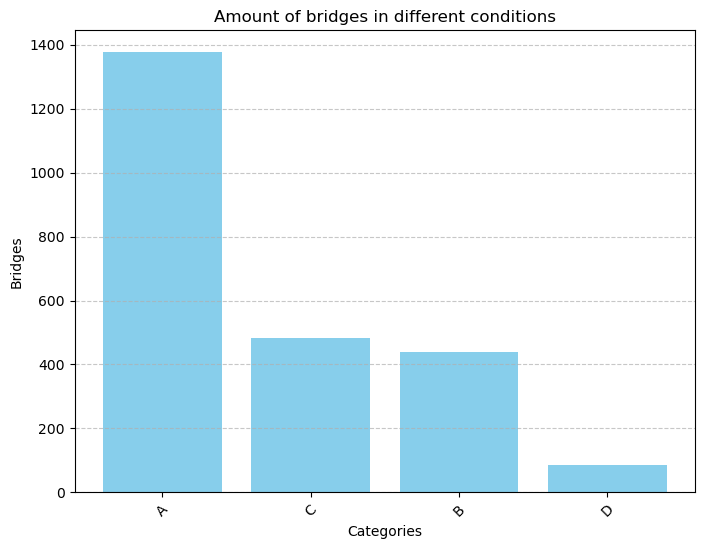

In [74]:
# Get value counts of the 'Category' column
value_counts = df_cleaned_coord['condition'].value_counts()


# Create bar plot using Pyplot
plt.figure(figsize=(8, 6))  
plt.bar(value_counts.index, value_counts.values, color='skyblue')
plt.title('Amount of bridges in different conditions')
plt.xlabel('Categories')
plt.ylabel('Bridges')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

In [75]:
print(df_cleaned_coord.condition.value_counts()/df_cleaned_coord.condition.value_counts().sum())

condition
A    0.577358
C    0.202096
B    0.184486
D    0.036059
Name: count, dtype: float64
